# Lecture 12: K-Means Clustering

MTU Spring 2024

Instructor: Abel Reyes

### Announcements

- HW6 will be released today or tomorrow.
- Quiz 2 grades on canvas.
- HW5 grading is in progress
- Midterm grading is in progress.

### Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:

- Explain the unsupervised paradigm. 
- Explain the motivation and potential applications of clustering. 
- Define the clustering problem. 
- Broadly explain the K-Means algorithm.  
- Apply `sklearn`'s `KMeans` algorithm.  
- Point out pros and cons of K-Means and the difficulties associated with choosing the right number of clusters.  

In [2]:
import os
import random
import sys
import time

import numpy as np

sys.path.append("code/.")
import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import *
from plotting_functions_unsup import *
from sklearn import cluster, datasets, metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn")

%matplotlib inline

C:\Users\sanjay\AppData\Local\Temp\ipykernel_10784\4170740194.py:20: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



## Introduction to unsupervised learning

### Types of machine learning 

Recall the typical learning problems we discussed in 571. 

- Supervised learning ([Gmail spam filtering](https://support.google.com/a/answer/2368132?hl=en))
    - Training a model from input data and its corresponding targets to predict targets for new examples. 
- **Unsupervised learning** (this course) ([Google News](https://news.google.com/))
    - Training a model to find patterns in a dataset, typically an unlabeled dataset.
- Reinforcement learning ([AlphaGo](https://deepmind.com/research/case-studies/alphago-the-story-so-far))
    - A family of algorithms for finding suitable actions to take in a given situation in order to maximize a reward. 
- **Recommendation systems** ([Amazon item recommendation system](https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf))
    - Predict the "rating" or "preference" a user would give to an item.    

### Supervised learning

- Training data comprises a set of observations ($X$) and their corresponding targets ($y$). 
- We wish to find a model function $f$ that relates $X$ to $y$.
- Then use that model function to predict the targets of new examples.
- We have been working with this set up so far. 

![](img/sup-learning.png)

### Unsupervised learning

- Training data consists of observations ($X$) without any corresponding targets.
- Unsupervised learning could be used to group similar things together in $X$ or to find underlying structure in the data. 

![](img/unsup-learning.png)

### Can we learn without targets?

- Yes, but the learning will be focused on finding the underlying structures of the inputs themselves (rather than finding the function $f$ between input and output like we did in supervised learning models). 

- Examples:
    - Clustering (this course)
    - Dimensionality reduction (requires some math, not covered in this course)

### Labeled vs. Unlabeled data
- If you have access to labeled training data, you're in the "supervised" setting. 
- You know what to do in that case from the previous lectures
- Unfortunately, getting large amount of labeled training data is often time consuming and expensive.
- Annotated data can become "stale" after a while in cases such as fraud detection. 
- Can you still make sense of the data even though you do not have the labels? 
- Yes! At least to a certain extent! 

### Example: Supervised vs unsupervised learning

- In supervised learning, we are given features $X$ and target $y$. 


<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> 101.0
                <td> Sick
            </tr>
            <tr>
                <td> 98.5 
                <td> Not Sick
            </tr>
            <tr>
                <td> 93.8 
                <td> Sick
            </tr>
            <tr>
                <td> 104.3
                <td> Sick
            </tr>
            <tr>
                <td> 98.6 
                <td> Not Sick
            </tr>
        </table>
    </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32 
                <td>class 1
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
                <td> class 1
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
                <td> class 2
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
                <td> class 2
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28 
                <td> class 3
            </tr>
        </table>
    </td>
</tr>
</table>

- In unsupervised learning, we are only given features $X$. 


<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
            </tr>
            <tr>
                <td> 101.0
            </tr>
            <tr>
                <td> 98.5 
            </tr>
            <tr>
                <td> 93.8 
            </tr>
            <tr>
                <td> 104.3
            </tr>
            <tr>
                <td> 98.6 
            </tr>
        </table>
    </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset 2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32 
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28 
            </tr>
        </table>
    </td>
</tr>
</table>


### Why clustering? 

- Most of the data out there is unlabeled.  
- Getting labeled training data is often difficult, expensive, or simply impossible in some cases. 
- Can we extract some useful information from unlabeled data? 
- The most intuitive way is to group similar examples together to get some insight into the data even though we do not have the targets.  

### Clustering  

**Clustering** is the task of partitioning the dataset into groups called clusters.

The goal of clustering is to discover underlying groups in a given dataset such that:
- examples in the same group are as similar as possible;
- examples in different groups are as different as possible.          

### Input and possible output

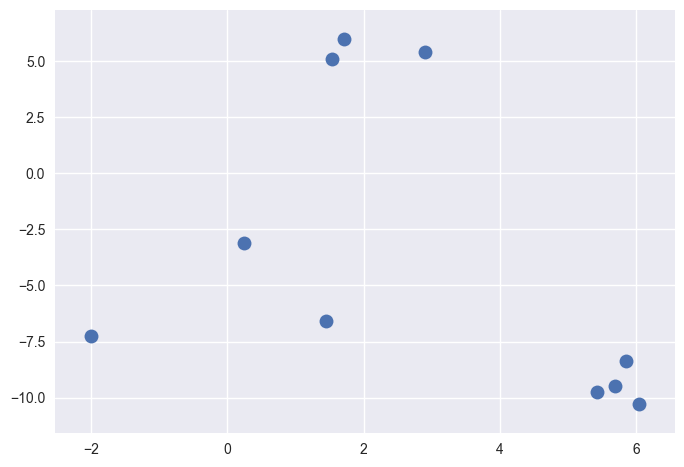

In [5]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
#fig, axes = plt.subplots(1, 2, figsize=(12, 4))
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o")#, ax=axes[0])


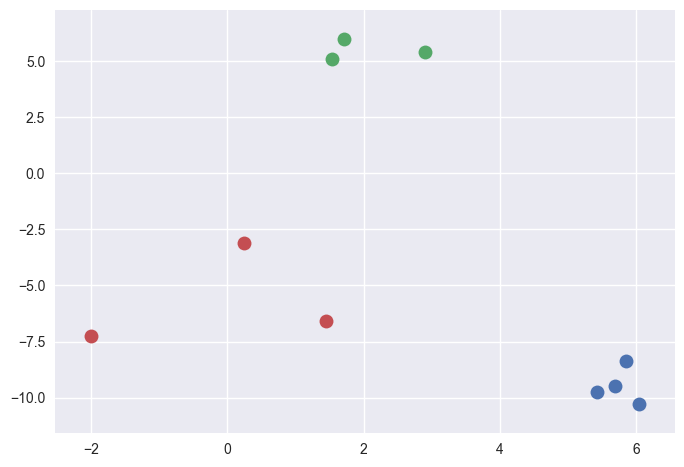

In [8]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, markers="o")#, ax=axes[1])

Think of clustering as colouring the points (e.g., blue, red, green) such that points with the same color are close to each other. 

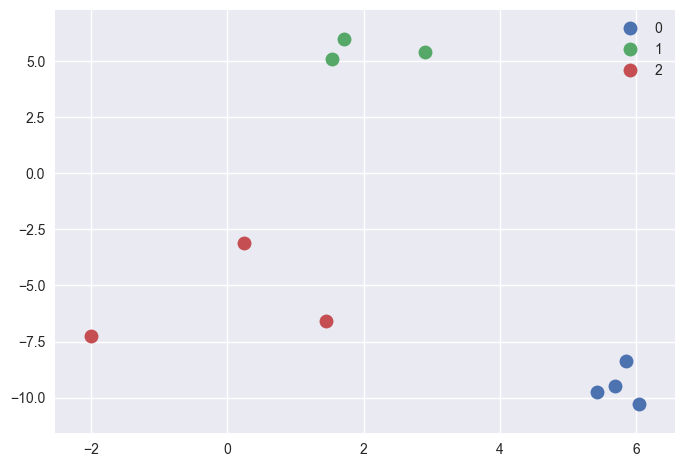

In [9]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, markers="o")
plt.legend();

- Usually the clusters are identified by a **cluster label**. 
- These labels are arbitrary, and relabeling the points (label switching) does not make a difference. 
- What we care about is which points have the same labels and which ones have different labels. 

### Is there a notion of "correct" grouping?

- Very often we do not know how many clusters are there in the data or if there are any clusters at all. In real-world data, clusters are rarely as clear as in our toy example above. 
- There is a notion of coherent and optimal (in some sense) clusters but there is no absolute truth here. 

### Example 1
Which of the following grouping of emoticons is the "correct" grouping?

![](img/emoticon_clustering_example.png)


Both seem reasonable! 

### Meaningful groups in clustering 
- In clustering, meaningful groups are dependent on the **application**.
- It usually helps if we have some prior knowledge about the data and the problem.   
- This makes it hard for us to objectively measure the quality of a clustering algorithm (or think about "true" clusters).

### Common applications: Data exploration

Although there is no notion of the "right" answer, we might still get something useful out of clustering. There are a number of common applications for clustering. 

- Summarize or compress data. 
- Partition the data into groups before further processing. 
- For instance, you could use it in supervised learning setting as follows. Carry out clustering and examine performance of your model on individual clusters. If the performance is lower on a particular cluster, you could either try building a separate model for that cluster and improve the overall performance of your supervised model. 

## Common applications: 

### Customer segmentation

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

![](img/customer-segmentation.png)

<!-- <img src="img/customer-segmentation.png" alt="" height="600" width="600">  -->

[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

### Document clustering

Grouping articles on different topics from different news sources. For example, [Google News](https://news.google.com). 

![](img/google_news.png)

<!-- <img src="img/google_news.png" alt="" height="1200" width="1200">  -->
    


## Color Quantization 
- It is the process of reducing number of colors in an image. 
- New image should have visually similarity as much as possible to the original image.
- **Why?** 
 - reduce the memory. 
 - some devices may have limitation on the number of colors
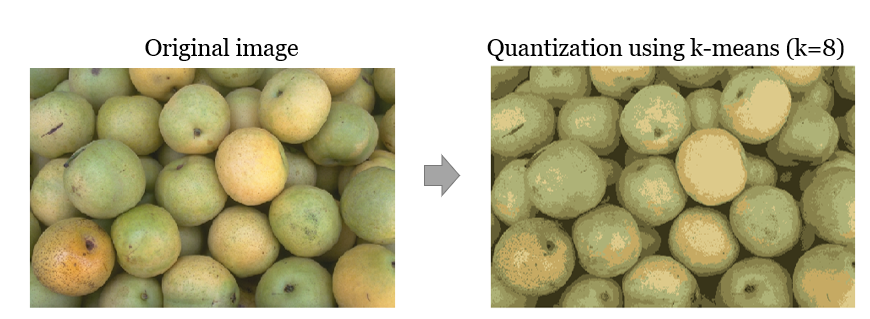

**You'll be working on Color Quantization in the homework assignment.**

### Similarity and distances

- Clustering is based on the notion of similarity or distances between points. 
- How do we determine similarity between points in a multi-dimensional space?
- Can we use something like Euclidean distances for similarity? 
    - Yes! That's a good start!  
    - We use Euclidean distances to find nearby points. 
    - We can use the same idea for clustering! 


## K-Means clustering algorithm 

### K-Means clustering 

One of the most commonly used clustering algorithm. 

**Input**
- `X` $\rightarrow$ a set of data points  
- `K` (or $k$ or `n_clusters`) $\rightarrow$ number of clusters

**Output**
- `K` clusters (groups) of the data points 



### K-Means using `sklearn`
- Before understanding the algorithm, let's try it with `sklearn`. 
- Consider the toy dataset above. 
- For this toy dataset, the three clusters are pretty clear.  

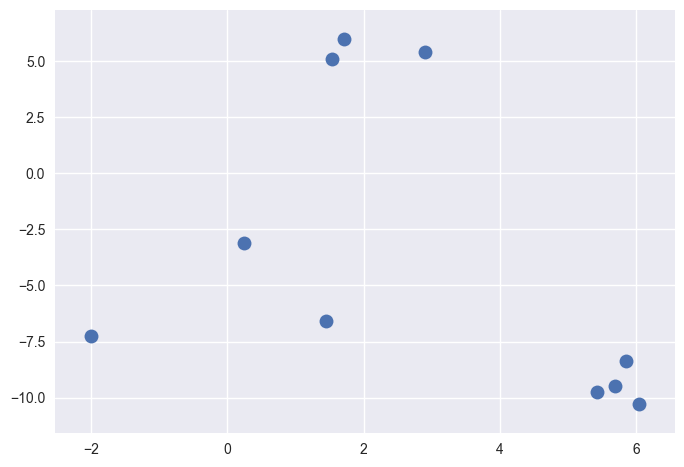

In [10]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [11]:
X

array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

In [12]:
toy_df = pd.DataFrame(data=X, columns=["feat1", "feat2"])
toy_df

,feat1,feat2
0,5.691924,-9.476412
1,1.707899,6.004352
2,0.236210,-3.119100
3,2.901595,5.421215
4,5.859439,-8.381924
5,6.047749,-10.305047
6,-2.007588,-7.247439
7,1.454677,-6.583872
8,1.536362,5.111215
9,5.430704,-9.759561


### `KMeans` `fit`
Let's try `sklearn`'s `KMeans` algorithm on this dataset.
- We need to decide how many clusters we want. Here we are passing 3. 
- We are only passing `X` because this is unsupervised learning; we do not have labels.  

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
# We are only passing X because this is unsupervised learning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=3)

### `predict` of `KMeans`

- The output of `KMeans` is $K$ clusters (groups) of the data points. 
- Calling `predict` will give us the cluster assignment for each data point. 

In [15]:
kmeans.predict(X)

array([0, 1, 2, 1, 0, 0, 2, 2, 1, 0])

In [16]:
toy_df_cl = toy_df.copy()
toy_df_cl["cluster"] = kmeans.predict(toy_df)
toy_df_cl

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but KMeans was fitted without feature names



,feat1,feat2,cluster
0,5.691924,-9.476412,0
1,1.707899,6.004352,1
2,0.236210,-3.119100,2
3,2.901595,5.421215,1
4,5.859439,-8.381924,0
5,6.047749,-10.305047,0
6,-2.007588,-7.247439,2
7,1.454677,-6.583872,2
8,1.536362,5.111215,1
9,5.430704,-9.759561,0


### Cluster centers in  K-Means

- In K-Means each cluster is represented by its cluster center. 

In [17]:
kmeans.cluster_centers_

array([[ 5.75745416, -9.48073598],
       [ 2.04861878,  5.51226051],
       [-0.10556679, -5.65013704]])

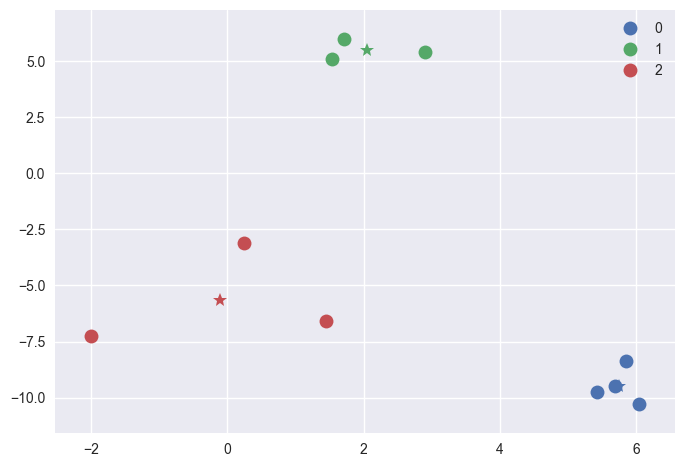

In [18]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers="*"
);

### K-Means predictions on new examples 
- We can also use `predict` on unseen examples!  

In [19]:
new_examples = np.array([[-1, -5], [2, 5.0]])
kmeans.predict(new_examples)

array([2, 1])

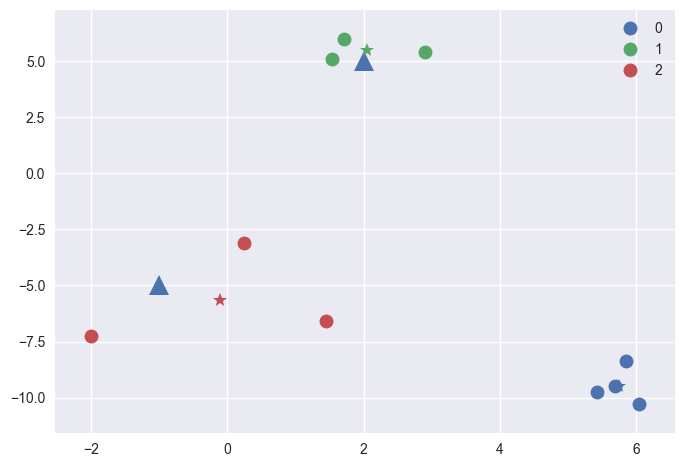

In [20]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
mglearn.discrete_scatter(new_examples[:, 0], new_examples[:, 1], markers="^", s=15)
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers="*"
);

### K-Means algorithm: Main idea 

- Represent each cluster by its cluster center and assign a cluster membership to each data point. 

**Chicken-and-egg problem!**

- If we knew cluster centers, we can simply assign each point to its nearest center.
- Similarly, if we knew assignments, we can calculate cluster centers.  
- But we do not know either 😟. 

A usual computer science answer to such problems is iterations!! 

### K-Means clustering algorithm

**Input**: Data points X and the number of clusters K

**Initialization**: K initial centers for the clusters

**Iterative process**:

repeat 
- Assign each example to the closest center.
- Estimate new centers as _average_ of observations in a cluster.

until **centers stop changing** or **maximum iterations have reached**.

Let's execute K-Means algorithm on our toy example. 

**Input**
- The data points `X`

In [21]:
n_examples = toy_df.shape[0]
print("Number of examples: ", n_examples)
X

Number of examples:  10


array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

- Let K (number of clusters) be 3. 

In [22]:
k = 3

### Initialization 

- Random initialization for K initial centers of the clusters. 

In [23]:
np.random.seed(seed=14)
centers_idx = np.random.choice(range(0, n_examples), size=k)
centers_df = toy_df.iloc[centers_idx]
centers = X[centers_idx]
colours = ["black", "blue", "red"]

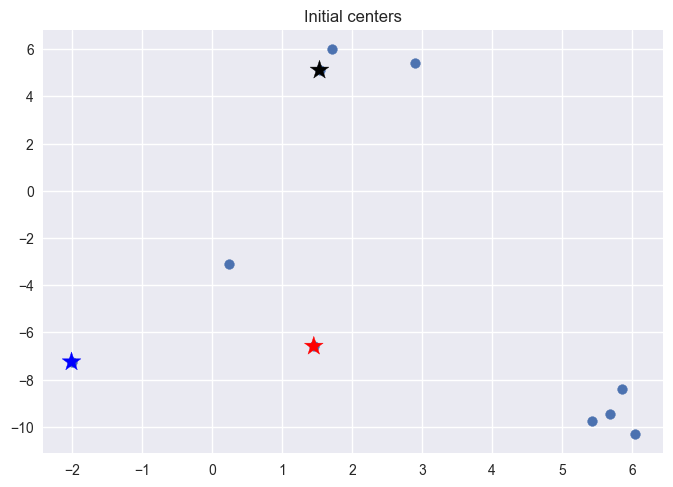

In [24]:
plt.scatter(X[:, 0], X[:, 1], marker="o")
plt.scatter(centers[:, 0], centers[:, 1], c=colours, marker="*", s=200)
plt.title("Initial centers");

### Iterative process

repeat 

- Assign each example to the closest center. (`update_Z`)
- Estimate new centers as _average_ of observations in a cluster. (`update_centers`)

until **centers stop changing** or **maximum iterations have reached**.

### How to find closest centers? 

- First step in the iterative process is assigning examples to the closest center. 
- Let's consider distance of an example to all centers and assign that example to the closest center.  

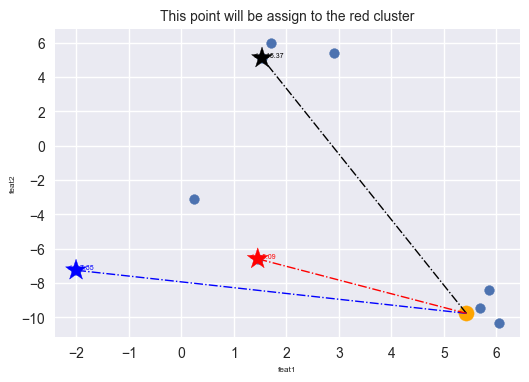

In [25]:
plot_example_dist(toy_df, centers_df, 6, 4)

## How to find closest centers?

- Similarly, we can make cluster assignments for all points by calculating distances of all examples to the centers and assigning it to the cluster with smallest distance.  

In [26]:
from sklearn.metrics import euclidean_distances


def update_Z(X, centers):
    """
    returns distances and updated cluster assignments
    """
    dist = euclidean_distances(X, centers)
    return dist, np.argmin(dist, axis=1)

### How to update centers?   

- With the new cluster assignments for our data points, we update cluster centers. 
- New cluster centers are means of data points in each cluster. 

In [27]:
def update_centers(X, Z, old_centers, k):
    """
    returns new centers
    """
    new_centers = old_centers.copy()
    for kk in range(k):
        new_centers[kk] = np.mean(X[Z == kk], axis=0)
    return new_centers

### Iteration 1: Step 1 

- Assign each example to the closest cluster center.


In [28]:
dist, Z = update_Z(X, centers)
Z

array([2, 0, 2, 0, 2, 2, 1, 2, 0, 2], dtype=int64)

- This is the current cluster assignment. 

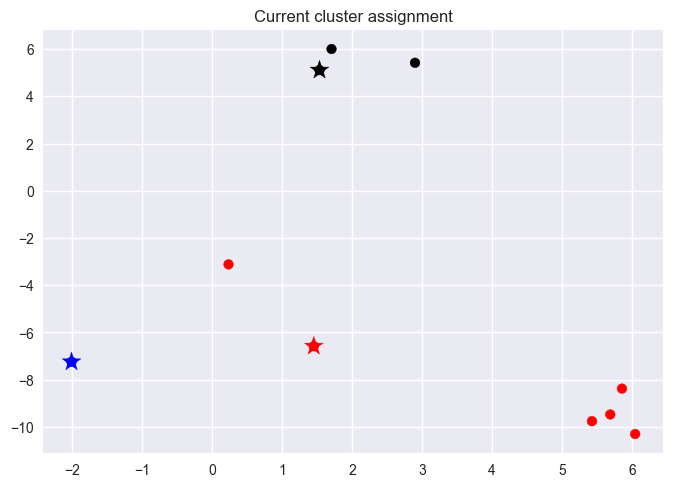

In [29]:
plot_current_assinment(X, Z, centers)

### Iteration 1: Step 2 
- Estimate new centers as _average_ of observations in a cluster.

In [30]:
new_centers_it1 = update_centers(X, Z, centers, k)

- This is how the centers moved in this iteration. 

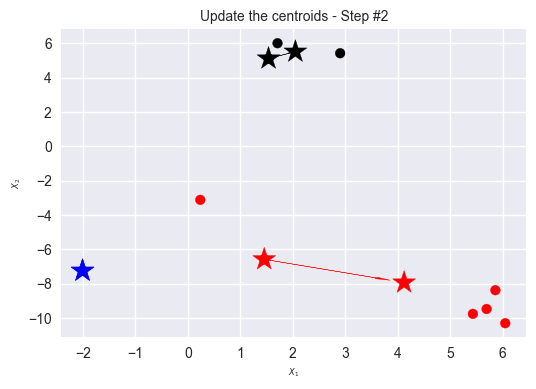

In [31]:
plot_update_centroid(toy_df, 6, 4, new_centers_it1, centers, dist)

### Iteration 2: step 1

- Assign each example to the closest cluster center.

In [32]:
dist, Z = update_Z(X, new_centers_it1)
Z

array([2, 0, 1, 0, 2, 2, 1, 2, 0, 2], dtype=int64)

In [33]:
dist

array([[15.42510922,  8.01566052,  2.19962711],
       [ 0.59853464, 13.76280538, 14.14914423],
       [ 8.81959206,  4.69870403,  6.18895669],
       [ 0.85782129, 13.5865701 , 13.41432622],
       [14.40731426,  7.94840674,  1.79516479],
       [16.31503124,  8.61611362,  3.05291946],
       [13.38890418,  0.        ,  6.16645506],
       [12.11070549,  3.5252805 ,  2.98953059],
       [ 0.65057235, 12.85674577, 13.30220745],
       [15.64183625,  7.85104763,  2.24432374]])

- This is the current cluster assignment. 

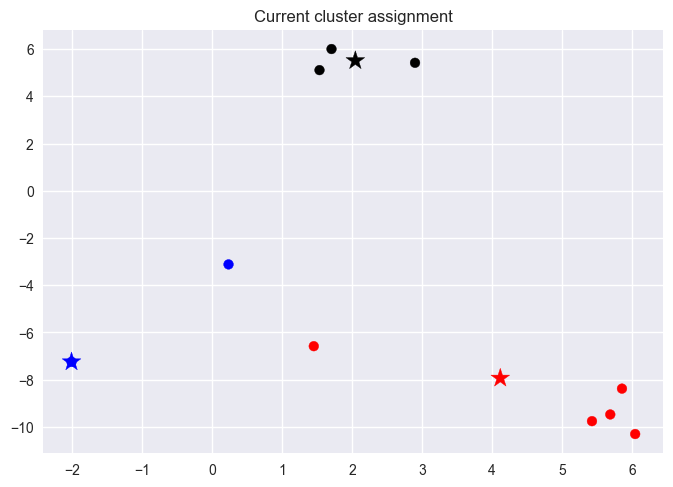

In [34]:
plot_current_assinment(X, Z, new_centers_it1)

### Iteration 2: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [35]:
new_centers_it2 = update_centers(X, Z, new_centers_it1, k)

- This is how the centers moved in this iteration. 

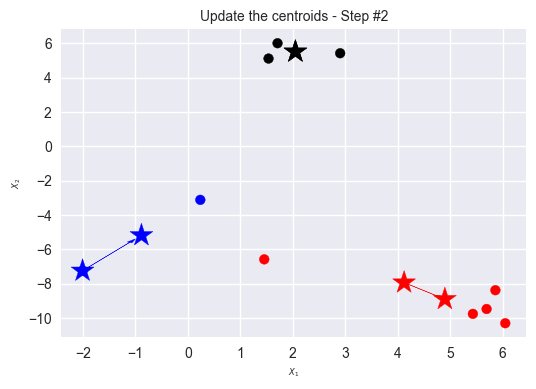

In [36]:
plot_update_centroid(toy_df, 6, 4, new_centers_it2, new_centers_it1, dist)

### Iteration 3: step 1

In [ ]:
###????

In [37]:
dist, Z = update_Z(X, new_centers_it2)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2], dtype=int64)

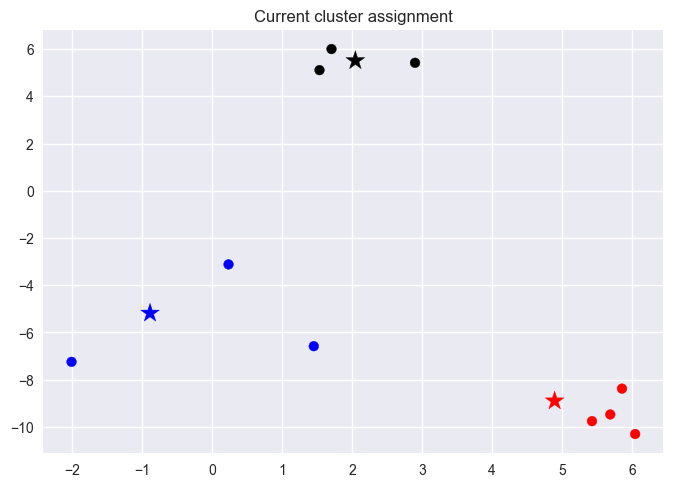

In [38]:
plot_current_assinment(X, Z, new_centers_it2)

In [ ]:
###????

In [41]:
new_centers_it3 = update_centers(X, Z, new_centers_it2, k)

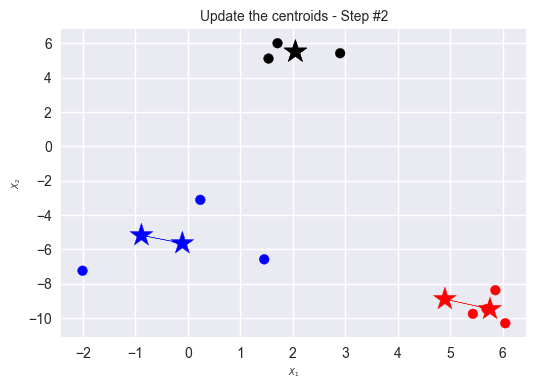

In [42]:
plot_update_centroid(toy_df, 6, 4, new_centers_it3, new_centers_it2, dist)

### Iteration 4: step 1

In [43]:
dist, Z = update_Z(X, new_centers_it3)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2], dtype=int64)

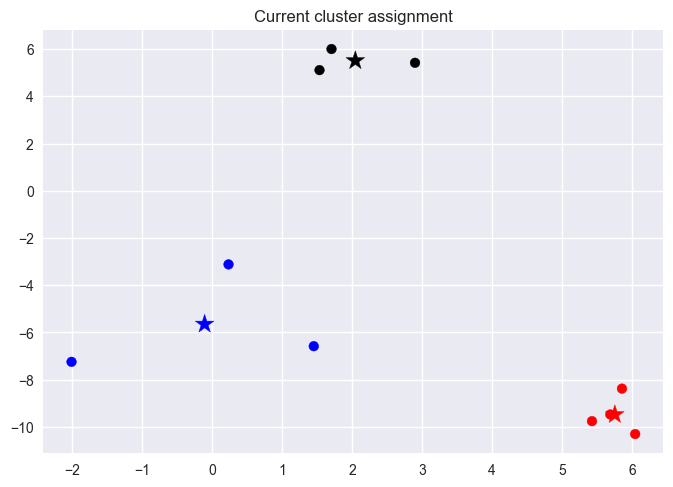

In [44]:
plot_current_assinment(X, Z, new_centers_it3)

### Iteration 4: step 2

In [45]:
new_centers_it4 = update_centers(X, Z, new_centers_it3, k)

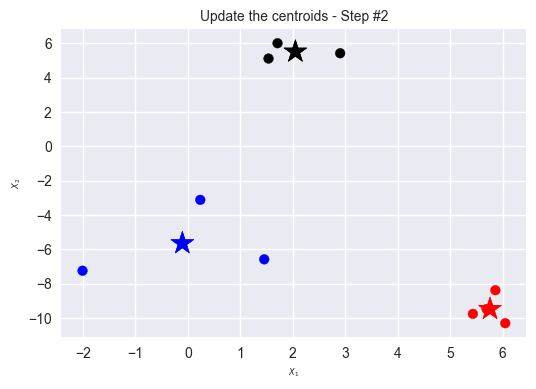

In [46]:
plot_update_centroid(toy_df, 6, 4, new_centers_it4, new_centers_it3, dist)

### Iteration 5: step 1

In [47]:
dist, Z = update_Z(X, new_centers_it4)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2], dtype=int64)

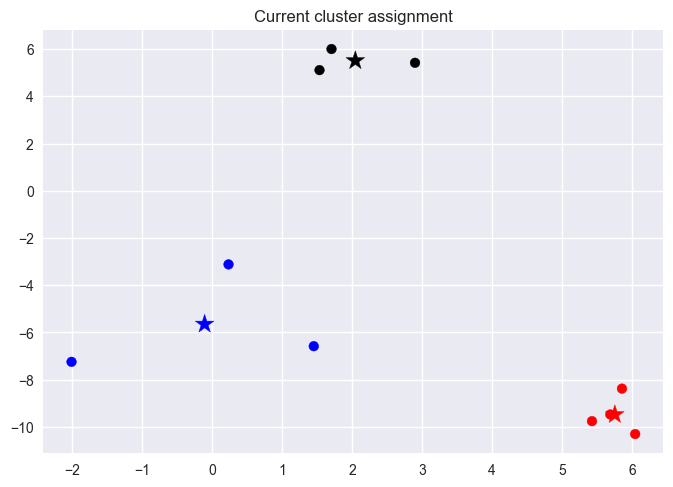

In [48]:
plot_current_assinment(X, Z, new_centers_it4)

### Iteration 5: step 2


In [49]:
new_centers_it5 = update_centers(X, Z, new_centers_it4, k)

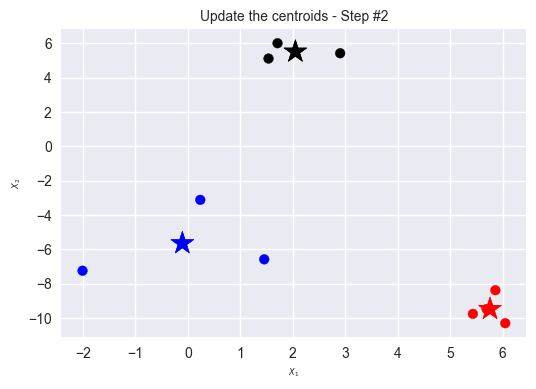

In [50]:
plot_update_centroid(toy_df, 6, 4, new_centers_it5, new_centers_it4, dist)

### When to stop?

- Seems like our centroids aren't changing anymore. 
- The algorithm has converged. So we stop! 
- K-Means always converges. It doesn't mean it finds the "right" clusters. It can converge to a sub-optimal solution.   

Initialization is crucial. We'll talk about it in a bit. 

### Example 2
- Let's use the K-means on the iris dataset. 

In [51]:
## Iris dataset
iris = datasets.load_iris()  # loading the iris dataset
features = iris.data  # get the input data
labels = iris.target_names[
    iris.target
]  # get the targets, in this case the types of the Iris flower

iris_df = pd.DataFrame(features, columns=iris.feature_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [53]:
np.unique(labels)

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [54]:
# Reducing the dimensionality for plotting purposes
# (We're going to learn more about it later in the course)
pca = PCA(n_components=2)
pca.fit(features)
data_iris = pd.DataFrame(pca.transform(features), columns=["$Z_1$", "$Z_2$"])
data_iris["target"] = labels

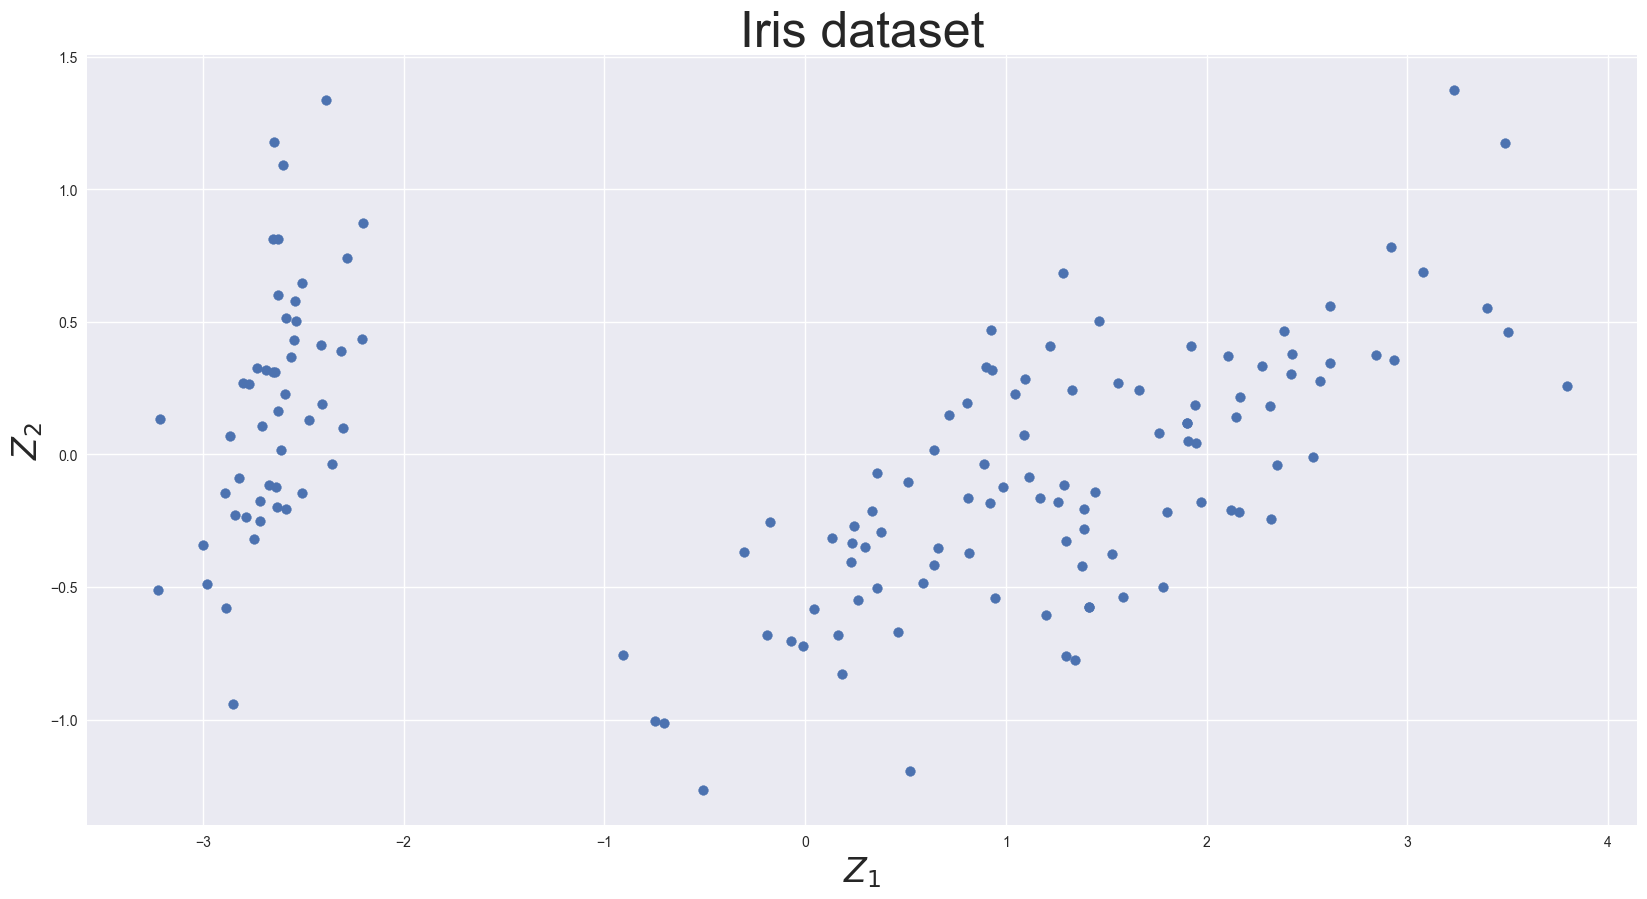

In [55]:
plot_unsup(data_iris, 20, 10, "Iris dataset")

#### Initialization

- In this case, we know that $k=3$;
- We are going to pick three points at random to use as initial centroids;

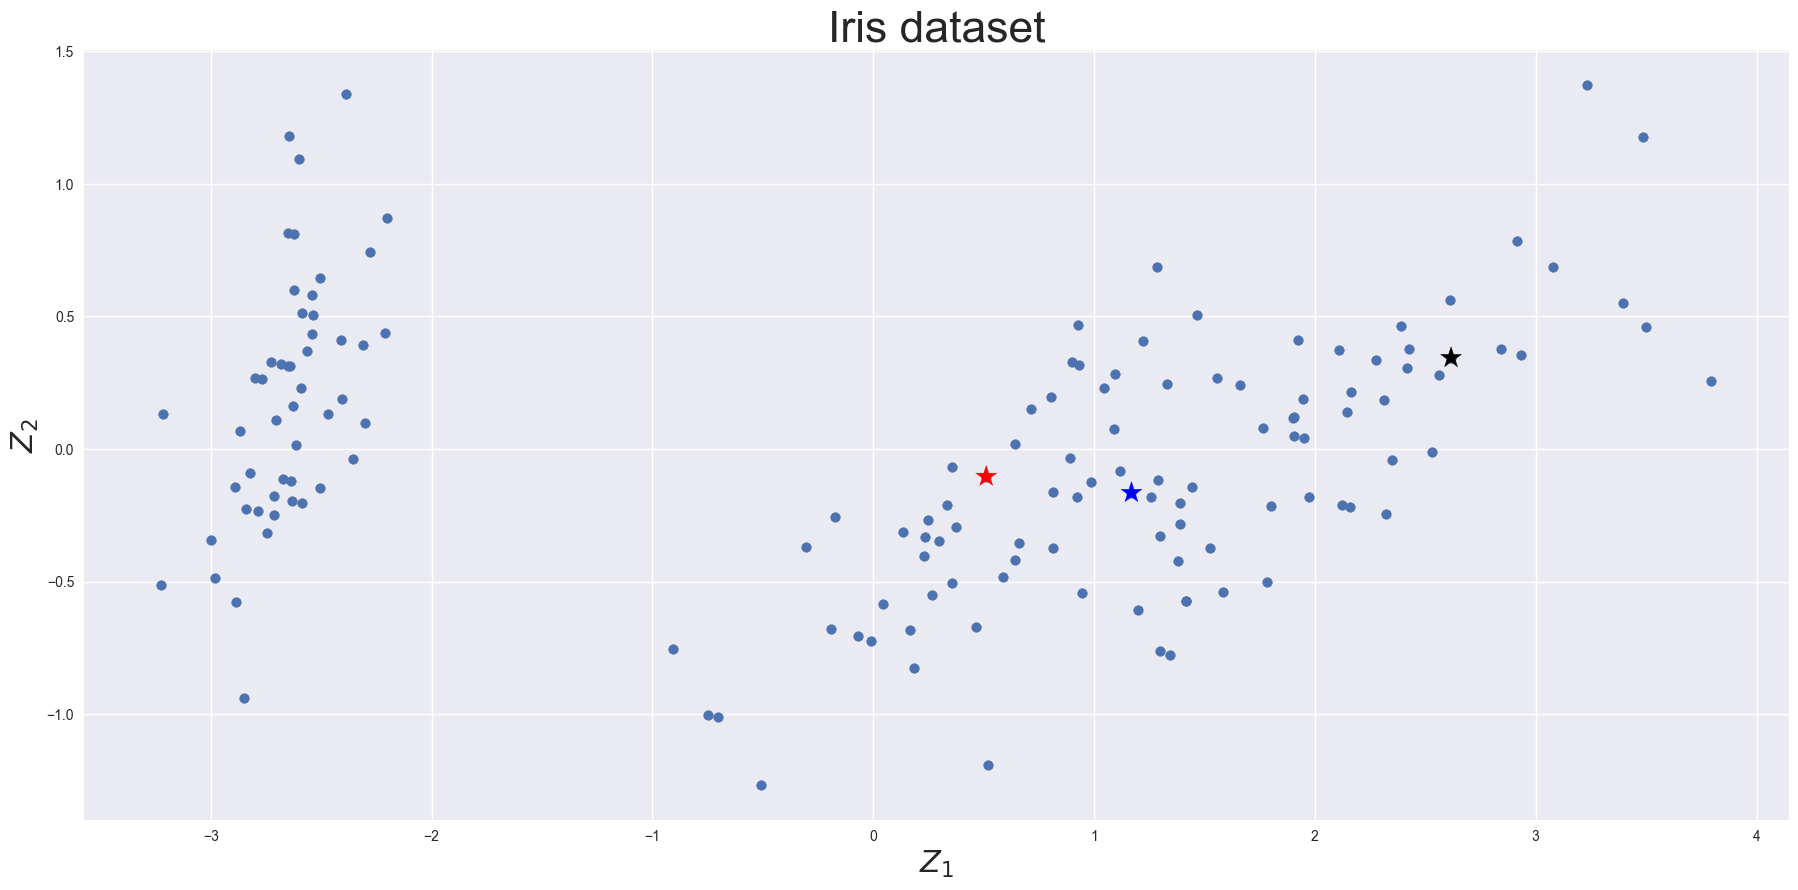

In [56]:
# RANDOM initialization
k = 3
centroids = np.random.choice(range(0, 150), size=k)
centroids = data_iris.iloc[centroids, 0:2]
plot_intial_center(data_iris, centroids, 22, 10, title="Iris dataset")

- Next, for each point in the dataset, we calculate the distance to each one of the centroids; 


- Let's do it for one point as example:

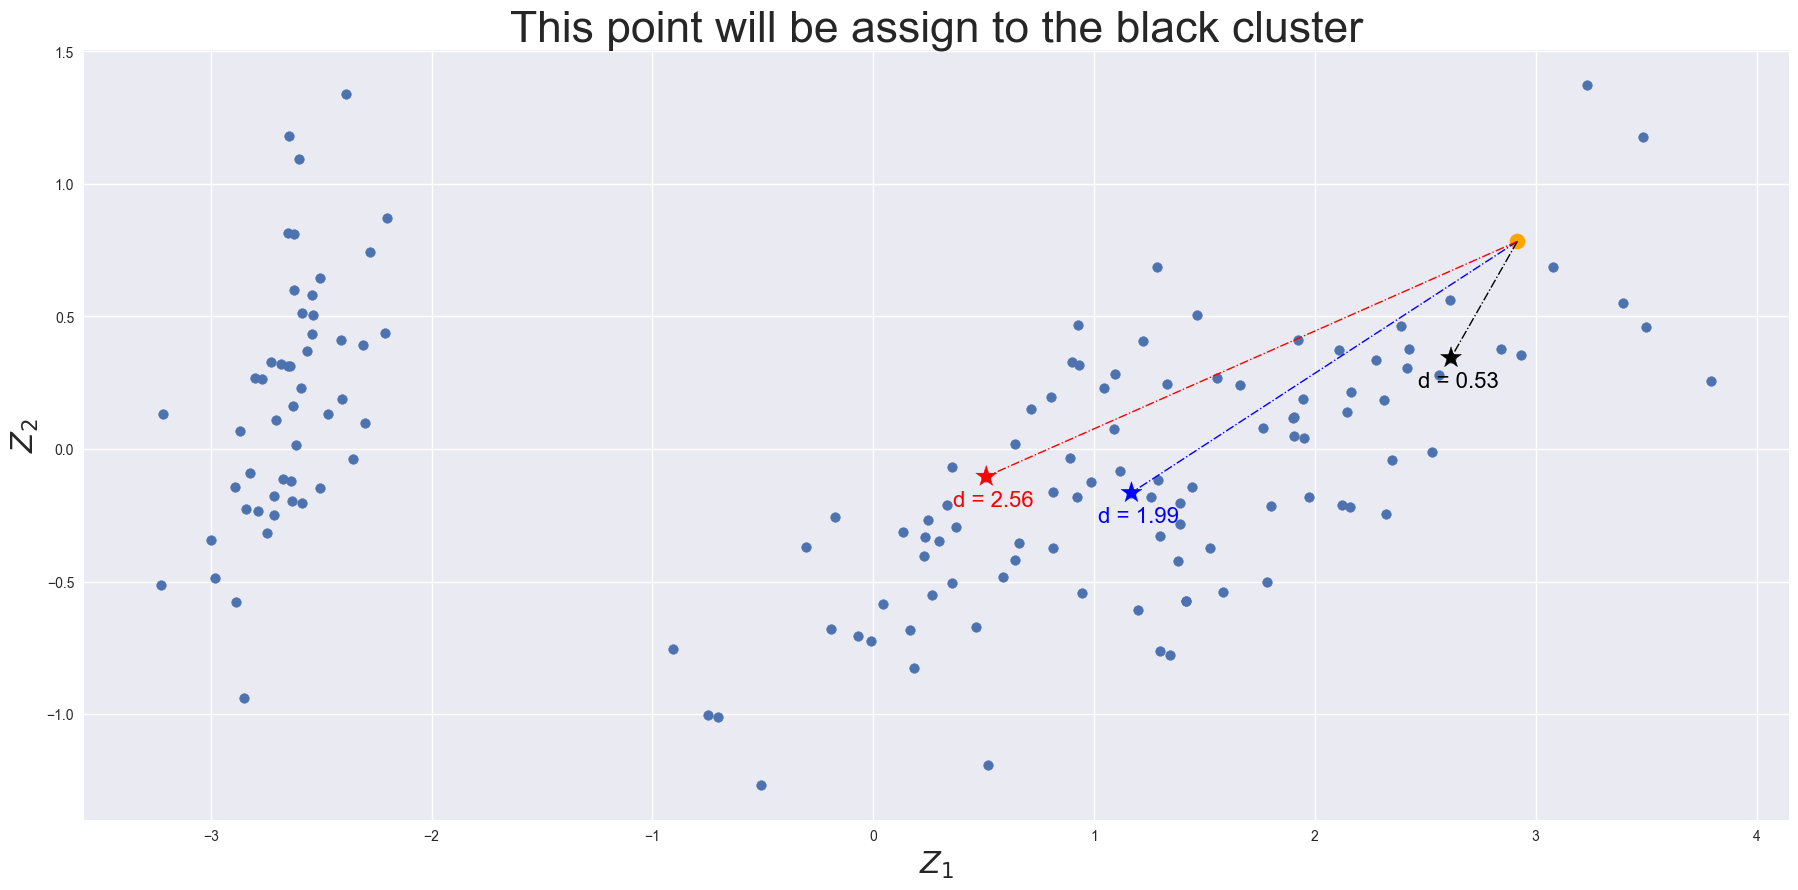

In [57]:
plot_example_dist(data_iris, centroids, 22, 10)

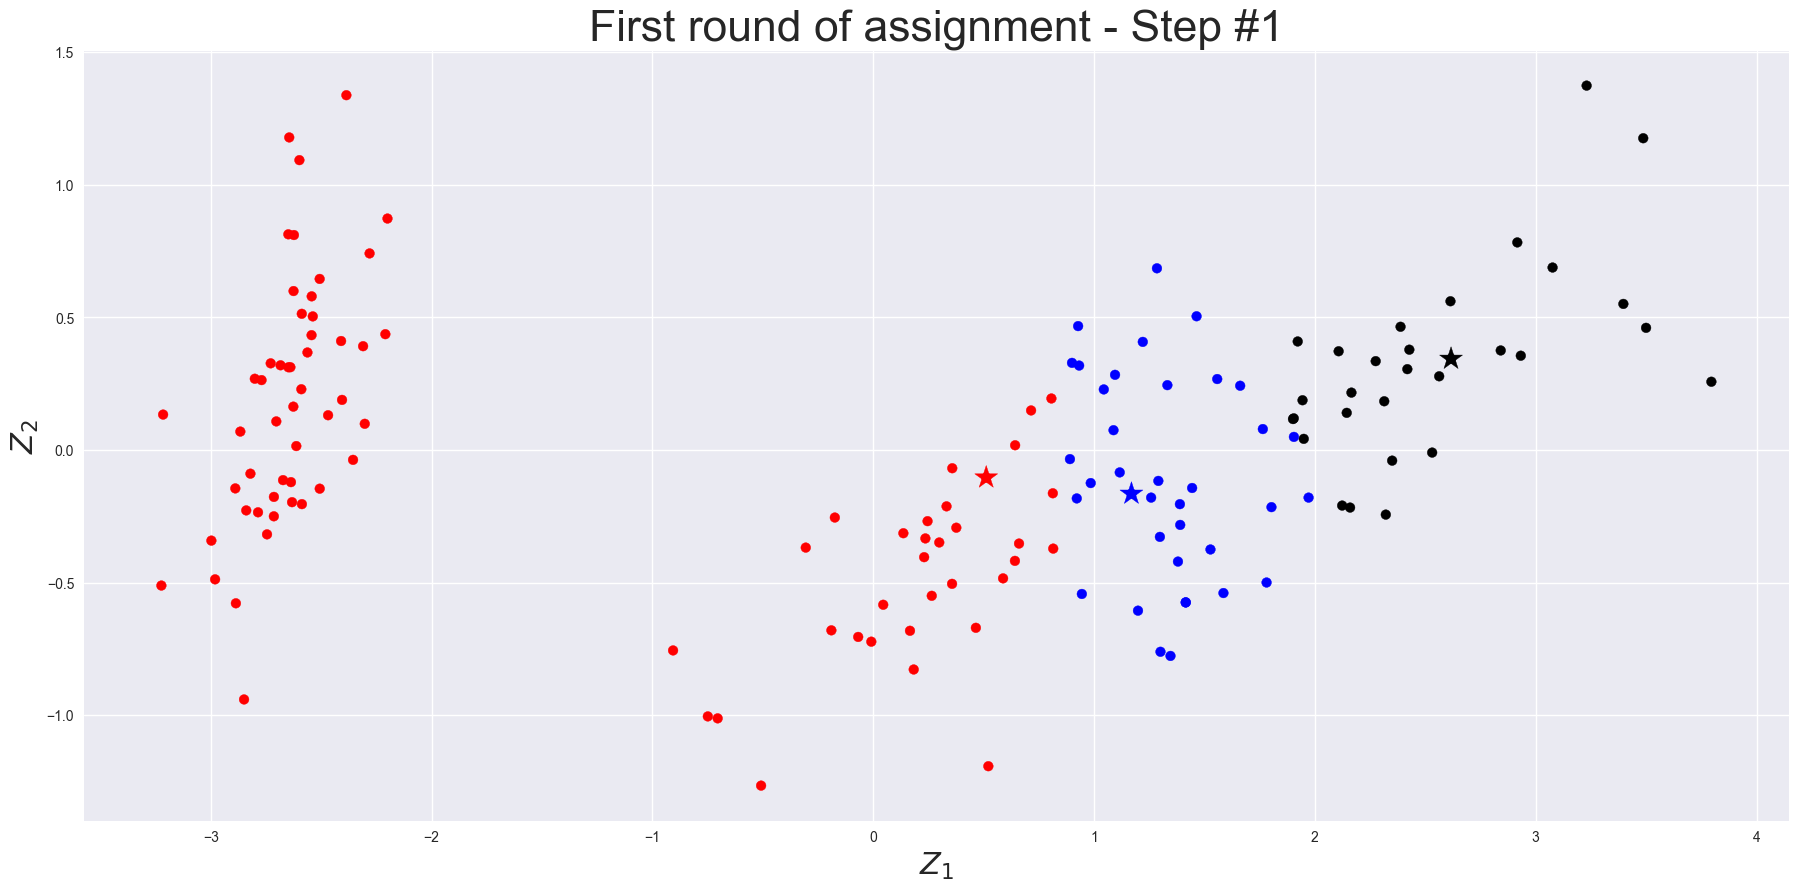

In [58]:
dist = distance.cdist(data_iris.iloc[:, 0:2], centroids.iloc[:, 0:2])
plot_first_assignment(data_iris, centroids, dist, 22, 10)

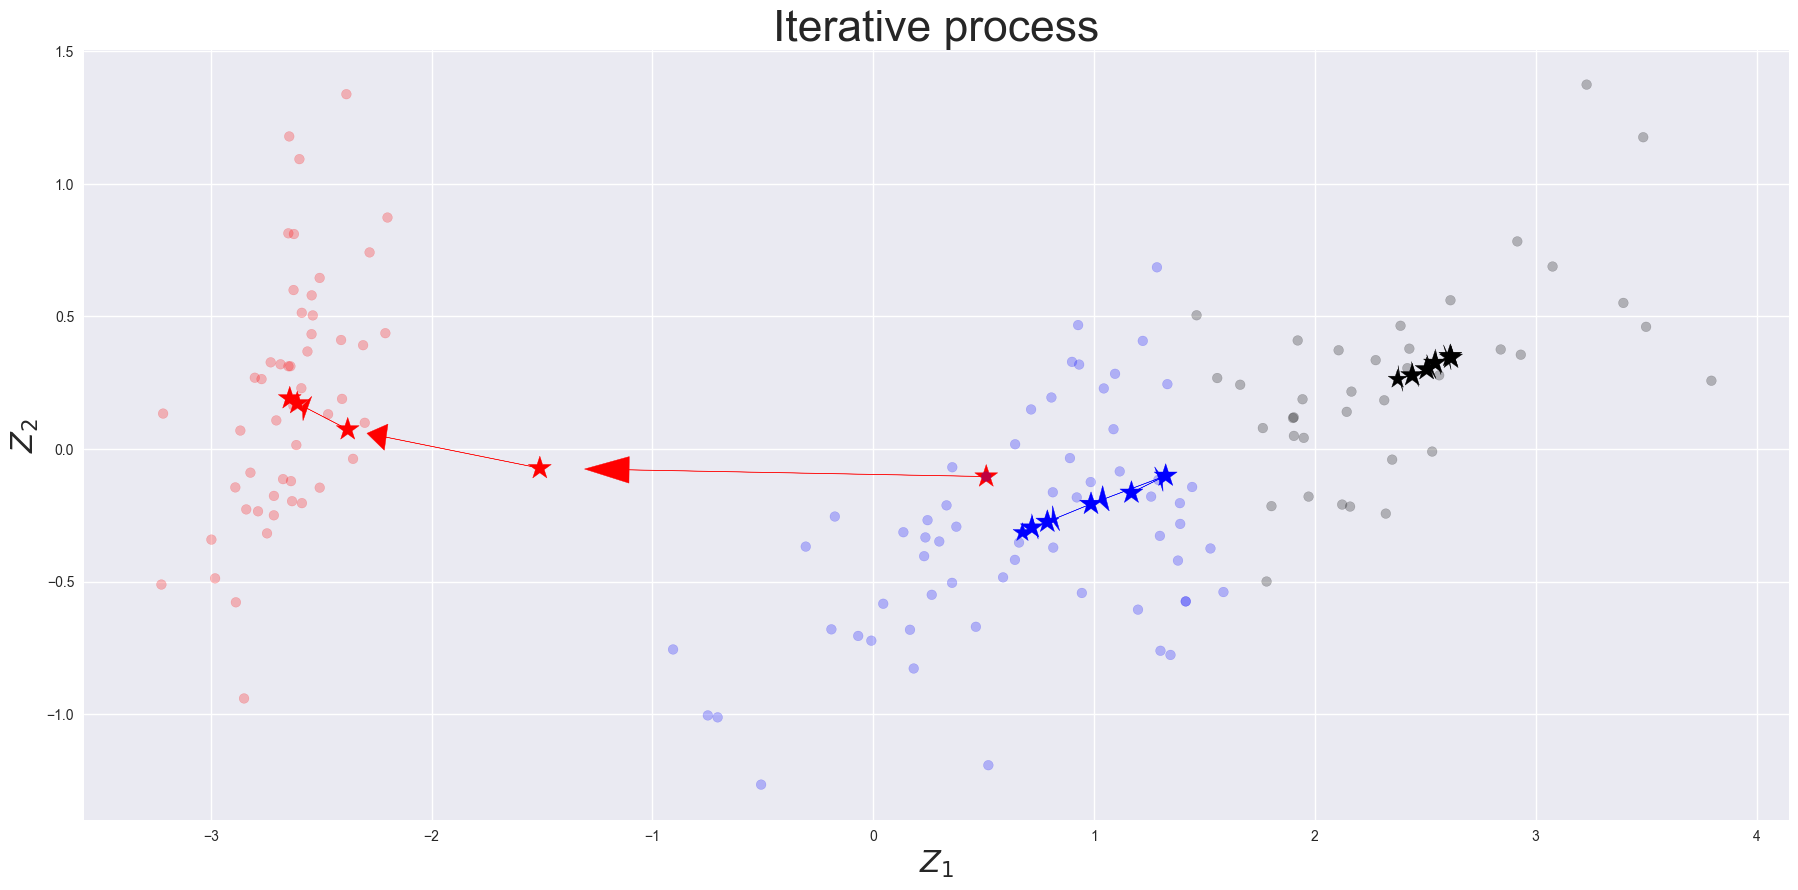

In [59]:
plot_iterative(data_iris, 22, 10, centroids.to_numpy())

## Choosing K

### Hyperparameter tuning for K

- K-Means takes K (`n_clusters` in `sklearn`) as a hyperparameter. How do we pick K? 

- In supervised setting we carried out hyperparameter optimization based on cross-validation scores. 

- Since in unsupervised learning we do not have the target values, it becomes difficult to objectively measure the effectiveness of the algorithms.

- There is no definitive approach.

- However, some strategies might be useful to help you determine K. 

### Method 1: The Elbow method

- This method looks at the sum of **intra-cluster distances**, which is also referred to as **inertia**. 
- The intra-cluster distance in our toy example above is given as   

$$\sum_{P_i \in C_1}  distance(P_i, C_1)^2 + \sum_{P_i \in C_2}  distance(P_i, C_2)^2 + \sum_{P_i \in C_3} distance(P_i, C_3)^2$$

Where 
- $C_1, C_2, C_3$ are centroids 
- $P_i$s are points within that cluster
- $distance$ is the usual Euclidean distance. 

### Inertia 

You can access this intra-cluster distance or inertia as follows. 

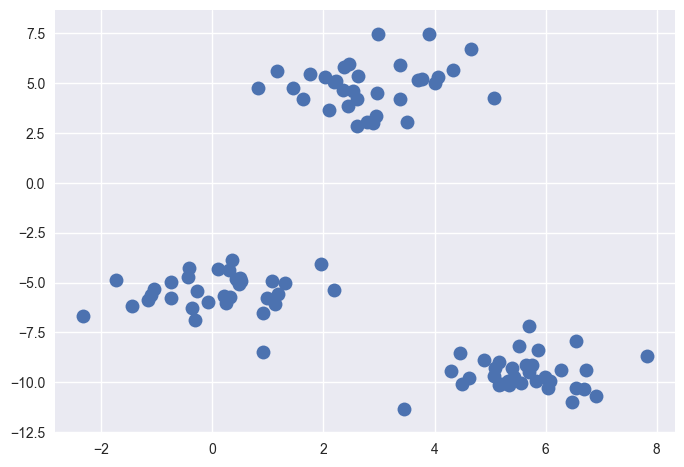

In [60]:
X, y = make_blobs(centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [62]:
d = {"K": [], "inertia": []}
for k in range(1, 100, 10):
    model = KMeans(n_clusters=k).fit(X)
    d["K"].append(k)
    d["inertia"].append(model.inertia_)

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can

In [63]:
pd.DataFrame(d)

,K,inertia
0,1,4372.460950
1,11,59.112714
2,21,24.396726
3,31,12.997736
4,41,6.368407
5,51,3.558211
6,61,1.930728
7,71,0.941090
8,81,0.325422
9,91,0.053156


- The inertia decreases as K increases. 
- Question: Do we want inertia to be small or large? 
- The problem is that we can't just look for a $k$ that minimizes inertia because it decreases as $k$ increases.
    - If I have number of clusters = number of examples, each example will have its own cluster and the intra-cluster distance will be 0.  
- Instead we evaluate the trade-off: "small k" vs "small intra-cluster distances". 

In [64]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h) / 2)
    ax.set_xlabel("K", fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can

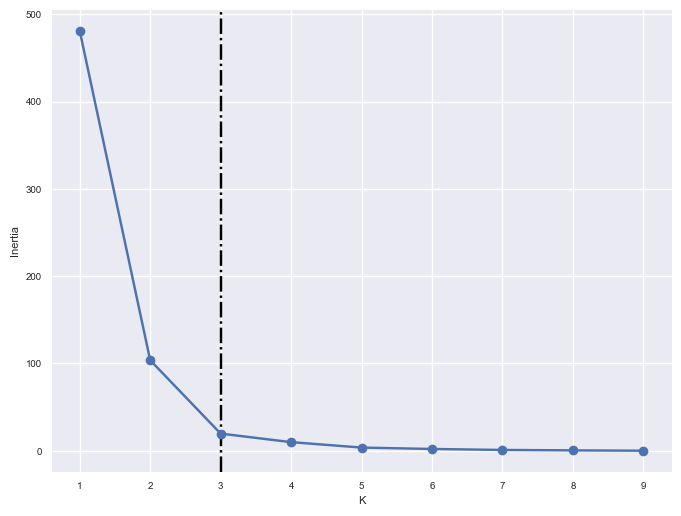

In [65]:
inertia_values = list()
for k in range(1, 10):
    inertia_values.append(KMeans(n_clusters=k).fit(toy_df).inertia_)
plot_elbow(8, 6, inertia_values)

- From the above plot, we could argue that three clusters (the point of inflection on the curve) are enough.
- The inertia decreases when clusters are greater than 3. However it's not a big improvement and so we prefer K=3. 
- In this toy example, it's the plot is kind of clear and easy to interpret but it can be hard to interpret in real life examples. 

There is a package called [`yellowbrick`](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) which can be used to create these plots conveniently. 

In [67]:
!pip install yellowbrick

     ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
     --------------- ---------------------- 112.6/282.6 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 282.6/282.6 kB 3.5 MB/s eta 0:00:00


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can

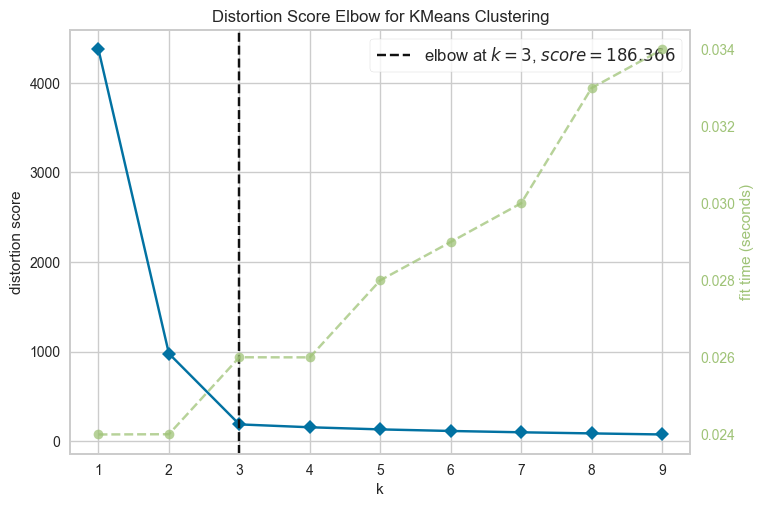

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can

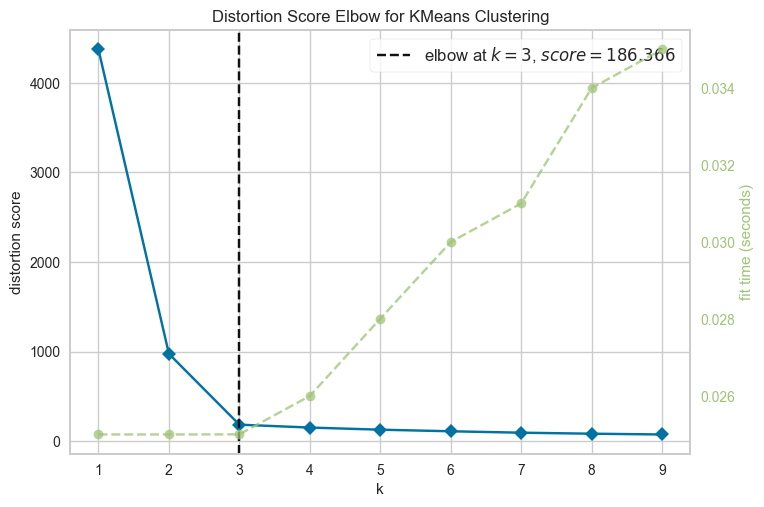

In [70]:
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.finalize();

In [71]:
visualizer.draw()

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

### A comment on initialization

- The initialization of K-Means is stochastic, can this affect the results?
    - Yes! Big time.  
- Let's  look at an example. 

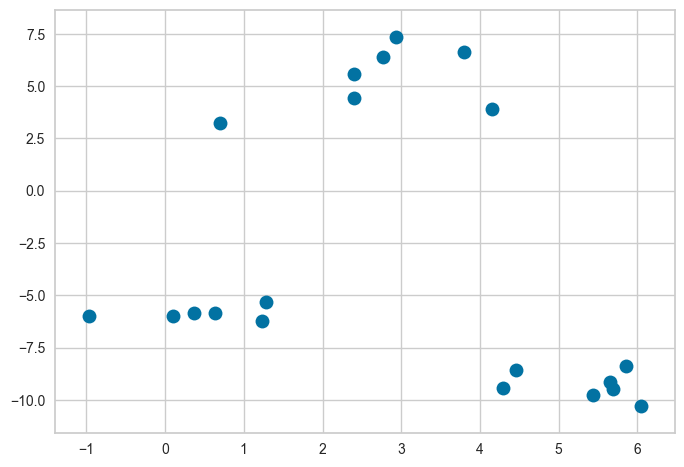

In [72]:
X, y = make_blobs(n_samples=20, centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [73]:
k = 3
n_examples = X.shape[0]
toy_df = pd.DataFrame(X, columns=["feat1", "feat2"])

### Example: Bad initialization 

In [74]:
np.random.seed(seed=10)
centroids_idx = np.random.choice(range(0, n_examples), size=k)
centroids = X[centroids_idx]

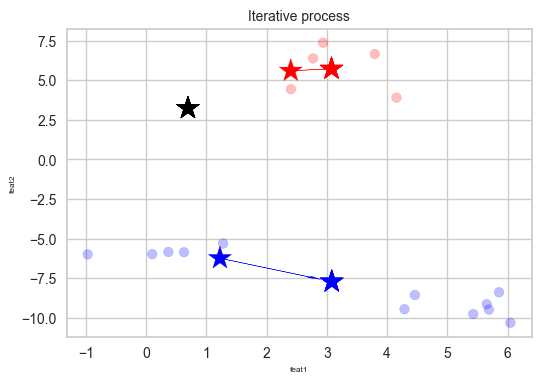

In [75]:
plot_iterative(toy_df, 6, 4, centroids)

### Example: Better initialization 
The following initialization seems much better. 

In [76]:
np.random.seed(seed=2)
centroids_idx = np.random.choice(range(0, n_examples), size=k)
centroids = X[centroids_idx]

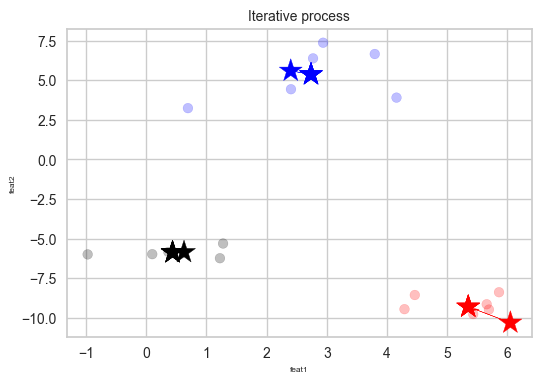

In [77]:
plot_iterative(toy_df, 6, 4, centroids)

### What can we do about it?

- One strategy is to run the algorithm several times. 
    - Check out `n_init` parameter of [`sklearn`'s `KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 
- Is it possible to pick `K` in a smart way? 
    - Yes! We can use the so-called [K-Means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).
    - Intuitively, it picks the initial centroids which are far away from each other. 
    - In other words, K-Means++ gives more chance to select points that are far away from centroids already picked.    
    - By default `sklearn` uses this strategy for initialization.

### Time complexity of K-Means

- Naive implementation of K-Means requires you to compute the distances from all data points to all cluster centers. 
- So there are many distance calculations per iteration. 
- calculating assigning observations to centers is heavy: $\mathcal{O(ndk)}$
- updating centers is light(er): $\mathcal{O(nd)}$

where, 

- $n \rightarrow$ number of examples
- $d \rightarrow$ number of features
- $k \rightarrow$ number of clusters


### Time complexity of K-Means

- There are more efficient exact algorithms. 
    - Elkan's (implemented in `scikit-learn`)
    - Ying-Yang
- Also, other approximate algorithms are being developed. 

### Important points to remember

- Clustering is a common unsupervised approach to identify underlying structure in data and grouping points based on similarity. 
- K-Means is a popular clustering algorithm.

### Important points to remember

**K-Means**
- It requires us to specify the number of clusters in advance. 
- Each example is assigned to one (and only one) cluster.
- The labels provided by the algorithm have no actual meaning. 
- The centroids live in the same space as of the dataset but they are **not** actual data points, but instead are average points.
- It always converges. Convergence is dependent upon the initial centers and it may converge to a sub-optimal solution. 